In [ ]:
from quantile_regression.fast_non_linear_vector_quantile_regression import FastNonLinearVectorQuantileRegression
from old_source_code.data import create_joint_x_y
import numpy as np
import torch
from utils import TrainParams

X, Y = create_joint_x_y(1000)
device_type_and_specification = {
    "device": "cpu",
    "dtype": torch.float64
}

X_batch = torch.from_numpy(np.concatenate([X, np.ones((1000, 1))], axis=1)).to(**device_type_and_specification)
Y_batch = torch.from_numpy(Y).to(**device_type_and_specification)
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_batch, Y_batch), batch_size=10, shuffle=True)

nlvqr = FastNonLinearVectorQuantileRegression(input_dimension=2, embedding_dimension=5, hidden_dimension=100, number_of_hidden_layers=1)
_ = nlvqr.fit(dataloader, train_params=TrainParams(num_epochs=2000, learning_rate=0.1, verbose=True))

# to save the model:
# nlvqr.save("nlvqr.pth")

100%|██████████| 2000/2000 [00:19<00:00, 104.80it/s]


/Users/vladimirkondratev/conditional_quantile_function/src/quantile_regression/fast_non_linear_vector_quantile_regression.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point = torch.tensor(point)


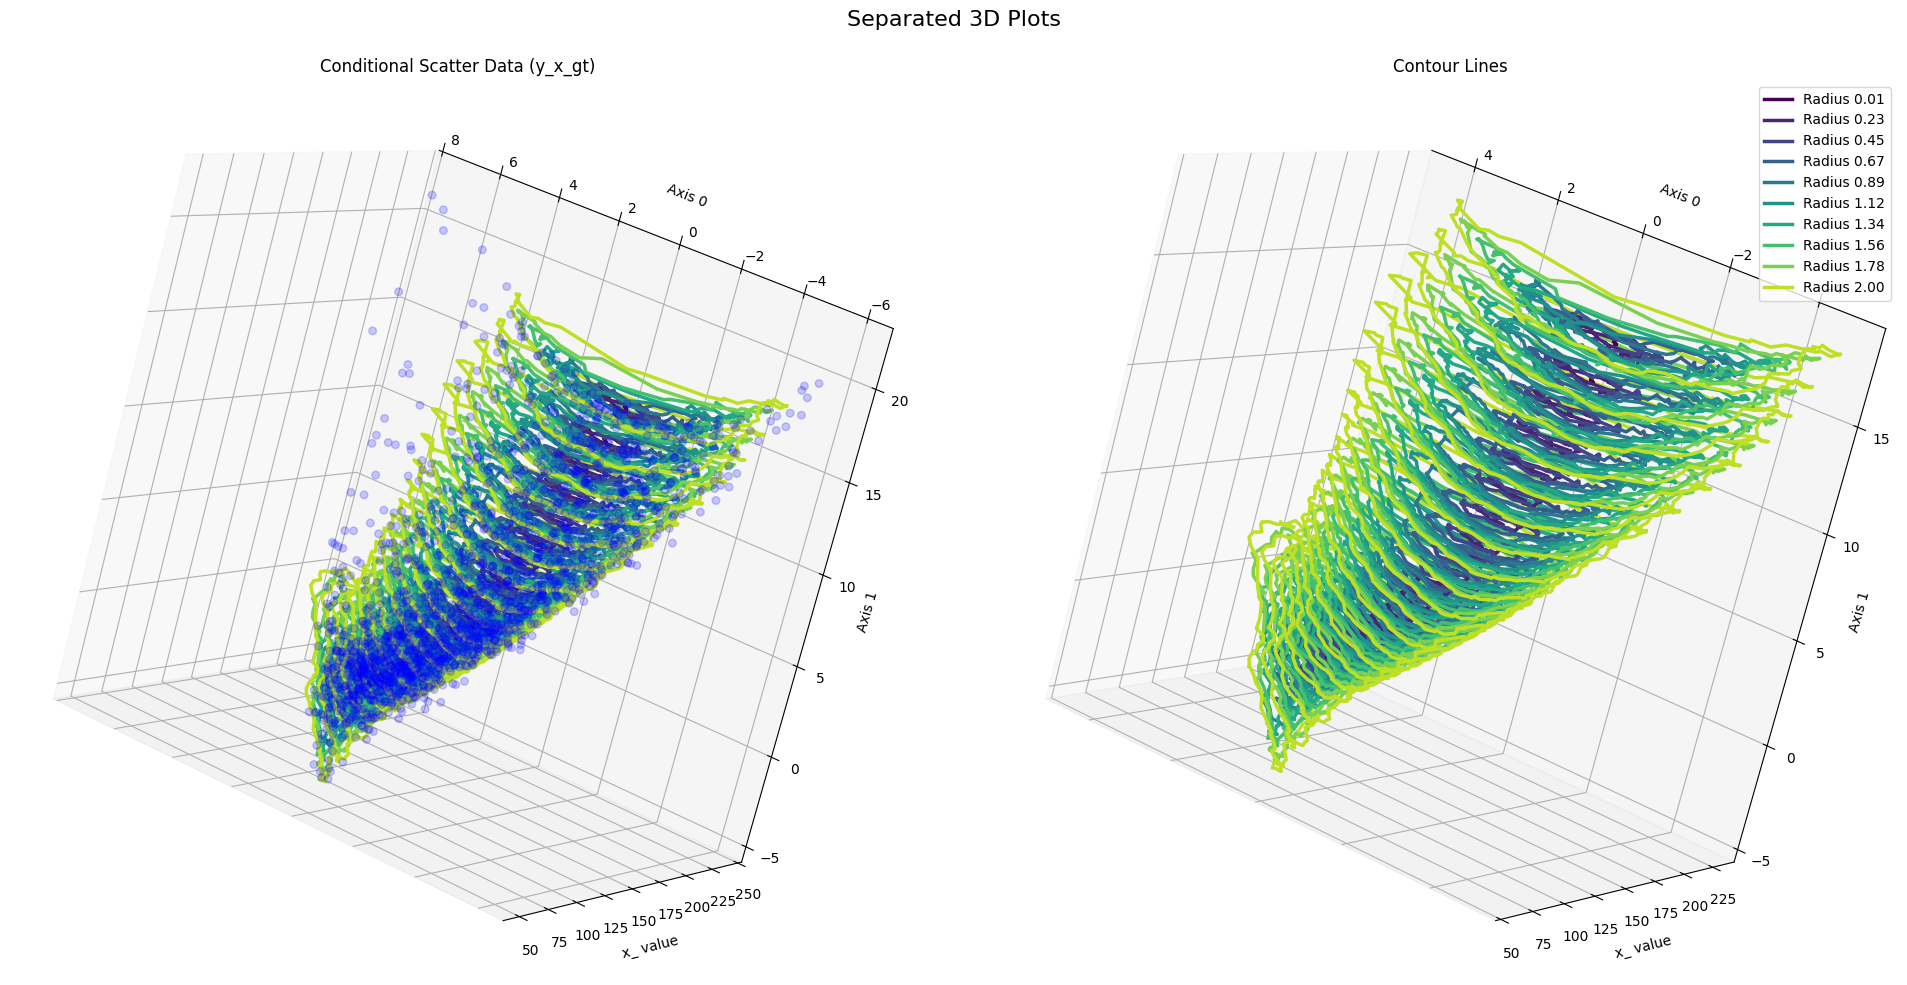

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from old_source_code.data import create_conditional_x
import matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100, 1])

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x[0])
    z_scatter = np.full(y_x_gt.shape[0], x_)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')
color_map = matplotlib.colormaps['viridis']

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = np.array([x_ / 100, 1])[None, :].repeat(100, 0)
    X_batch = torch.from_numpy(x)

    radii = np.linspace(0.01, 2, 10)
    colors = [color_map(i / len(radii)) for i in range(len(radii))]
    for contour_radius, color in zip(radii, colors):
        pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

        u = np.stack([
            contour_radius * np.cos(pi),
            contour_radius * np.sin(pi),
        ]).T

        pushforward_of_u = nlvqr.push_forward_u_given_x(torch.from_numpy(u), X=X_batch).detach().cpu().numpy()
        z_line = np.full(pushforward_of_u.shape[0], x_)

        label = f'Radius {contour_radius:.2f}' if x_ == loop_start_value else ""
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()